In [2]:
from keras.datasets.cifar10 import load_data
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model


In [3]:
(trainx, trainy), (testx, testy) = load_data()

In [4]:
from matplotlib import pyplot as plt

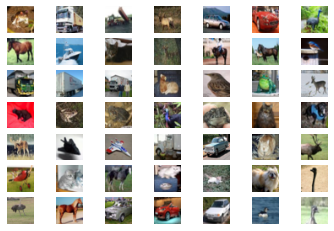

In [5]:
for i in range(49):
  plt.subplot(7,7,i+1)
  plt.axis('off')
  plt.imshow(trainx[i])

In [6]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model
def build_discriminator(in_shape):
  model = Sequential()
  model.add(Conv2D(64,(3,3), input_shape = in_shape, padding = 'same'))
  model.add(LeakyReLU(alpha = 0.2))
  model.add(Dropout(0.4))
  model.add(Conv2D(64,(3,3), input_shape = in_shape, padding = 'same'))
  model.add(LeakyReLU(alpha = 0.2))
  model.add(Dropout(0.4))
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='sigmoid'))
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 65536)             0

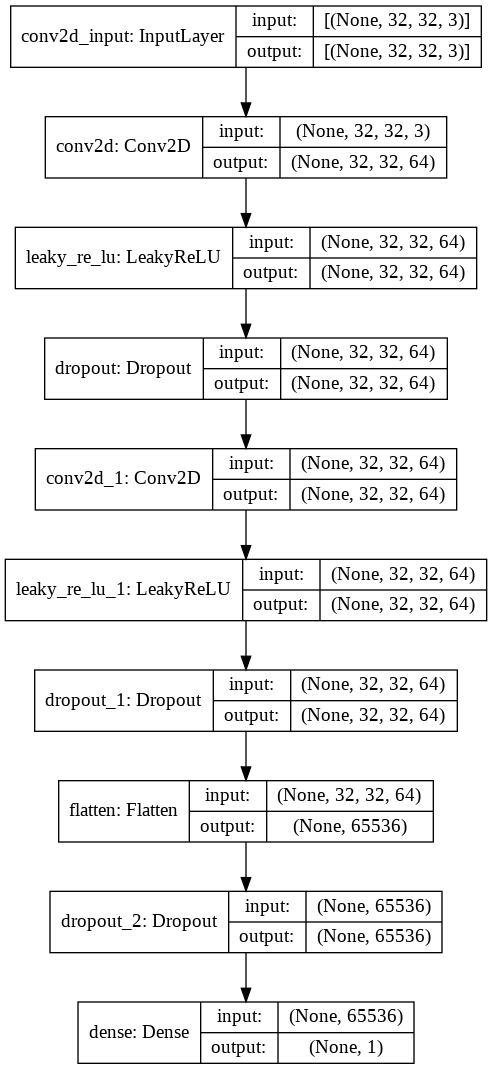

In [7]:
d_model = build_discriminator((32,32,3))
d_model.summary()
plot_model(d_model, to_file='test.png', show_shapes=True, show_layer_names=True)

In [8]:
def load_real_samples():
  (trainX, _), (_, _) = load_data()
  X = trainX.astype('float32')
  X = (X - 127.5) / 127.5
  return X

In [9]:
from numpy.random import randint
from numpy import ones
def generate_real_samples(dataset, n_batch):
  ix = randint(0, dataset.shape[0], n_batch)
  X = dataset[ix]
  y = ones((n_batch, 1))
  return X, y

In [10]:
from numpy import zeros
from numpy.random import rand
def generate_fake_samples(n_batch):
  X = rand(32*32*3*n_batch)
  X = -1 + X * 2
  X = X.reshape((n_batch, 32, 32, 3))
  y = zeros((n_batch, 1))
  return X, y

In [11]:
def train_discriminator(model, dataset, n_iter=20, n_batch=128):
  half_batch = int(n_batch/2)
  for i in range(n_iter):
    x_real, y_real = generate_real_samples(dataset, half_batch)
    x_fake, y_fake = generate_fake_samples(half_batch)
    _, real_acc = model.train_on_batch(x_real, y_real)
    _, fake_acc = model.train_on_batch(x_fake, y_fake)
    print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))


In [12]:
data = load_real_samples()
d_model = build_discriminator((32,32,3))
train_discriminator(d_model, data)

>1 real=55% fake=0%
>2 real=94% fake=3%
>3 real=80% fake=20%
>4 real=70% fake=62%
>5 real=69% fake=83%
>6 real=70% fake=91%
>7 real=89% fake=98%
>8 real=78% fake=97%
>9 real=80% fake=100%
>10 real=84% fake=100%
>11 real=88% fake=100%
>12 real=86% fake=100%
>13 real=97% fake=100%
>14 real=95% fake=100%
>15 real=97% fake=100%
>16 real=100% fake=100%
>17 real=97% fake=100%
>18 real=100% fake=100%
>19 real=100% fake=100%
>20 real=97% fake=100%


In [13]:
def build_generator(latent_dim):
  n_nodes = 4*4*256
  model = Sequential()
  model.add(Dense(n_nodes, input_dim = latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((4, 4, 256)))

  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
  return model


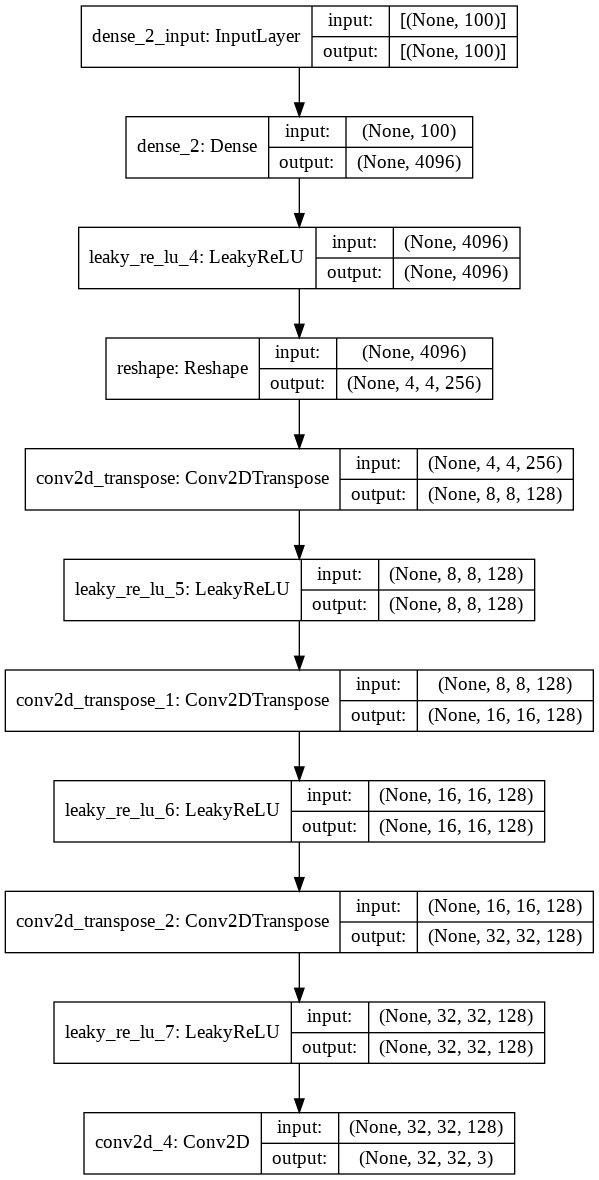

In [14]:
latent_dim = 100
g_model = build_generator(latent_dim)
plot_model(g_model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

In [15]:
from numpy.random import randn
def generate_latent_points(latent_dim, n_batch):
  x_input = randn(latent_dim * n_batch)
  x_input = x_input.reshape(n_batch, latent_dim)
  return x_input
def generate_fake_samples(generator, latent_dim, n_batch):
  input = generate_latent_points(latent_dim, n_batch)
  X = generator.predict(input)
  y = zeros((n_batch, 1))
  return X, y


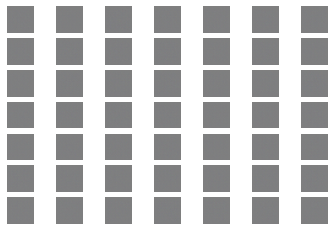

In [16]:
latent_dim = 100
generator = build_generator(latent_dim)
X, _ = generate_fake_samples(generator, latent_dim, 49)
X = (X + 1) / 2.0
for i in range (49):
  plt.subplot(7,7,i+1)
  plt.axis('off')
  plt.imshow(X[i])
plt.show()


In [17]:
def build_gan(generator, discriminator):
  discriminator.trainable=False
  model = Sequential()
  model.add(generator)
  model.add(discriminator)
  opt = Adam(lr = 0.0002, beta_1 = 0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model

In [18]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=200, n_batch=128):
  bat_per_epo = int(dataset.shape[0] / n_batch)
  half_batch = int(n_batch/2)
  for i in range(n_epochs):
    for j in range(bat_per_epo):
      x_real, y_real = generate_real_samples(dataset, half_batch)
      x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      d_loss1, _ = d_model.train_on_batch(x_real, y_real)
      d_loss2, _ = d_model.train_on_batch(x_fake, y_fake)
      x_gan = generate_latent_points(latent_dim, n_batch)
      y_gan = ones((n_batch, 1))
      g_loss = gan_model.train_on_batch(x_gan, y_gan)
      print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
      if (i+1) % 5 == 0 and (j == 1 or j == 349):
        summarize_performance(i, g_model, d_model, dataset, latent_dim)


In [19]:
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
  # prepare real samples
  X_real, y_real = generate_real_samples(dataset, n_samples)
  # evaluate discriminator on real examples
  _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
  # prepare fake examples
  x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
  # evaluate discriminator on fake examples
  _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
  # summarize discriminator performance
  print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
  save_plot(x_fake, epoch)

In [20]:
def save_plot(examples, epoch, n=7):
  # scale from [-1,1] to [0,1]
  examples = (examples + 1) / 2.0
  # plot images
  for i in range(n * n):
    # define subplot
    plt.subplot(n, n, 1 + i)
    # turn off axis
    plt.axis('off')
    # plot raw pixel data
    plt.imshow(examples[i])
    plt.show()

In [ ]:
latent_dim = 100
# create the discriminator
d_model = build_discriminator(in_shape=(32,32,3))
# create the generator
g_model = build_generator(latent_dim)
# create the gan
gan_model = build_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

>1, 1/390, d1=0.679, d2=0.700 g=0.686
>1, 2/390, d1=0.349, d2=0.715 g=0.671
>1, 3/390, d1=0.194, d2=0.747 g=0.646
>1, 4/390, d1=0.116, d2=0.802 g=0.607
>1, 5/390, d1=0.089, d2=0.869 g=0.574
>1, 6/390, d1=0.081, d2=0.933 g=0.568
>1, 7/390, d1=0.084, d2=0.916 g=0.637
>1, 8/390, d1=0.085, d2=0.763 g=0.844
>1, 9/390, d1=0.139, d2=0.587 g=1.011
>1, 10/390, d1=0.179, d2=0.568 g=0.955
>1, 11/390, d1=0.186, d2=0.631 g=0.829
>1, 12/390, d1=0.159, d2=0.686 g=0.759
>1, 13/390, d1=0.165, d2=0.727 g=0.721
>1, 14/390, d1=0.120, d2=0.751 g=0.718
>1, 15/390, d1=0.141, d2=0.755 g=0.718
>1, 16/390, d1=0.206, d2=0.783 g=0.706
>1, 17/390, d1=0.156, d2=0.818 g=0.704
>1, 18/390, d1=0.108, d2=0.851 g=0.729
>1, 19/390, d1=0.163, d2=0.896 g=0.794
>1, 20/390, d1=0.236, d2=0.884 g=0.937
>1, 21/390, d1=0.169, d2=0.695 g=1.227
>1, 22/390, d1=0.177, d2=0.489 g=1.330
>1, 23/390, d1=0.177, d2=0.493 g=1.143
>1, 24/390, d1=0.225, d2=0.596 g=0.855
>1, 25/390, d1=0.107, d2=0.685 g=0.736
>1, 26/390, d1=0.075, d2=0.720 g=0